## 1.1 Library Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import seaborn as sns
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn import metrics

from sklearn.impute import KNNImputer

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif

# Data Encoder and Scaler
import category_encoders as encoders
from sklearn.preprocessing import LabelEncoder, RobustScaler

from imblearn.over_sampling import SMOTE

## 1.2 Load Data

In [2]:
df_train = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
df_test = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")
df_greeks = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")

print(f'No. of records for train : {df_train.shape}')
print(f'No. of records for test : {df_test.shape}')
print(f'No. of records for greeks : {df_greeks.shape}')

No. of records for train : (617, 58)
No. of records for test : (5, 57)
No. of records for greeks : (617, 6)


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

## 2. EDA

## 2.1 Distribution of Target Label

In [4]:
df_train["Class"].value_counts()

0    509
1    108
Name: Class, dtype: int64

([<matplotlib.patches.Wedge at 0x7a843c1df1f0>,
 [Text(-0.9378309675672217, 0.5748678772308721, '0'),
  Text(0.9378309137442025, -0.5748679650369418, '1')],
 [Text(-0.5115441641275754, 0.3135642966713847, '509\n(82.50%)'),
  Text(0.511544134769565, -0.31356434456560456, '108\n(17.50%)')])

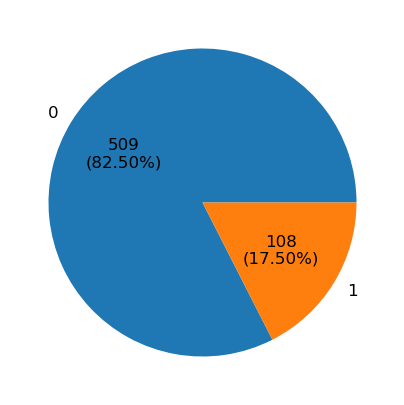

In [5]:
plt.figure(figsize=(5,5))

def auto_fmt(pct_value):
    return f"{(df_train['Class'].value_counts().sum() * pct_value / 100):.0f}\n({pct_value:.2f}%)"

fig = plt.gcf()
plt.pie(x=df_train['Class'].value_counts(), labels=["0", "1"], autopct=auto_fmt, textprops={'fontsize': 12})

## 2.2 Missing Value Analysis

In [6]:
df_train_numerical = df_train.drop(["Id", "EJ", "Class"], axis=1)

<Axes: xlabel='feature'>

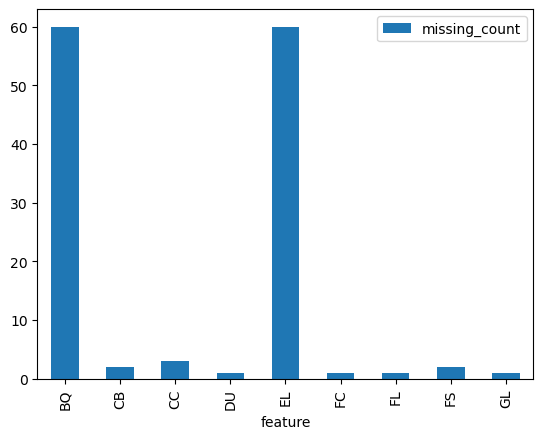

In [7]:
df_train_missing = df_train_numerical.isna().sum()
df_train_missing = df_train_missing.reset_index()
df_train_missing.columns = ["feature", "missing_count"]

df_train_missing = df_train_missing.loc[df_train_missing["missing_count"] > 0]

df_train_missing.plot.bar(x='feature', y='missing_count')

## 2.3 Descriptive Analysis

In [8]:
df_train_numerical.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AB,617.0,0.477149,0.468388,0.081187,0.252107,0.354659,0.559763,6.161666
AF,617.0,3502.013221,2300.322717,192.593280,2197.345480,3120.318960,4361.637390,28688.187660
AH,617.0,118.624513,127.838950,85.200147,85.200147,85.200147,113.739540,1910.123198
AM,617.0,38.968552,69.728226,3.177522,12.270314,20.533110,39.139886,630.518230
AR,617.0,10.128242,10.518877,8.138688,8.138688,8.138688,8.138688,178.943634
AX,617.0,5.545576,2.551696,0.699861,4.128294,5.031912,6.431634,38.270880
AY,617.0,0.060320,0.416817,0.025578,0.025578,0.025578,0.036845,10.315851
AZ,617.0,10.566447,4.350645,3.396778,8.129580,10.461320,12.969516,38.971568
BC,617.0,8.053012,65.166943,1.229900,1.229900,1.229900,5.081244,1463.693448
BD,617.0,5350.388655,3021.326641,1693.624320,4155.702870,4997.960730,6035.885700,53060.599240


## Data Pre-Processing for Model Data

## 3.1 Missing Value Imputation - kNN Imputer

In [9]:
imputer = KNNImputer(n_neighbors=10)
numerical_columns = df_train_numerical.columns

df_train_imputed = pd.DataFrame(imputer.fit_transform(df_train[numerical_columns]), columns=numerical_columns)
df_test_imputed = pd.DataFrame(imputer.fit_transform(df_test[numerical_columns]), columns=numerical_columns)

In [10]:
print(f"{df_train_imputed.isnull().sum()}")

AB     0
AF     0
AH     0
AM     0
AR     0
AX     0
AY     0
AZ     0
BC     0
BD     0
BN     0
BP     0
BQ     0
BR     0
BZ     0
CB     0
CC     0
CD     0
CF     0
CH     0
CL     0
CR     0
CS     0
CU     0
CW     0
DA     0
DE     0
DF     0
DH     0
DI     0
DL     0
DN     0
DU     0
DV     0
DY     0
EB     0
EE     0
EG     0
EH     0
EL     0
EP     0
EU     0
FC     0
FD     0
FE     0
FI     0
FL     0
FR     0
FS     0
GB     0
GE     0
GF     0
GH     0
GI     0
GL     0
dtype: int64


In [11]:
print(df_train_imputed.shape)
print(df_test_imputed.shape)

(617, 55)
(5, 55)


In [12]:
df_train_categorical = df_train.drop(numerical_columns, axis=1)
categorical_train_columns = df_train_categorical.columns

df_test_categorical = df_test.drop(numerical_columns, axis=1)
categorical_test_columns = df_test_categorical.columns

df_train_2 = pd.concat([df_train_imputed, df_train_categorical], axis=1)
df_test_2 = pd.concat([df_test_imputed, df_test_categorical], axis=1)

print(f"Shape of the Train data set : {df_train_2.shape}")
print(f"Shape of the Test data set : {df_test_2.shape}")

Shape of the Train data set : (617, 58)
Shape of the Test data set : (5, 57)


In [13]:
df_test_2

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,Id,EJ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00eed32682bb,A
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,010ebe33f668,A
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,02fa521e1838,A
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,040e15f562a2,A
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,046e85c7cc7f,A


## 3.2 Data Standarization for Numerical Features

In [14]:
scaler = RobustScaler()

scaler_train = scaler.fit_transform(df_train_2[numerical_columns])
scaler_df_train = pd.DataFrame(scaler_train, columns=numerical_columns)

scaler_test = scaler.fit_transform(df_test_2[numerical_columns])
scaler_df_test = pd.DataFrame(scaler_test, columns=numerical_columns)

print(f"Shape of Scaled Train Data set : {scaler_df_train.shape}")
print(f"Shape of Scaled Test Data set : {scaler_df_test.shape}")

Shape of Scaled Train Data set : (617, 55)
Shape of Scaled Test Data set : (5, 55)


In [15]:
df_train_2 = pd.concat([scaler_df_train, df_train_categorical], axis=1)
df_test_2 = pd.concat([scaler_df_test, df_test_categorical], axis=1)

print(f"Shape of Train Data set : {df_train_2.shape}")
print(f"Shape of Test Data set : {df_test_2.shape}")

Shape of Train Data set : (617, 58)
Shape of Test Data set : (5, 57)


## 3.3 Data Encoding for Categorical Features

In [16]:
CATBoostENCODE = encoders.CatBoostEncoder()

categorical_cols = ["EJ"]

encoder_train = CATBoostENCODE.fit_transform(df_train_2[categorical_cols], df_train_2["Class"])
encoded_df_train = pd.DataFrame(encoder_train)

encoder_test = CATBoostENCODE.transform(df_test_2[categorical_cols])
encoded_df_test = pd.DataFrame(encoder_test)

print(f"Shape of Train Data set : {encoded_df_train.shape}")
print(f"Shape of Test Data set : {encoded_df_test.shape}")

Shape of Train Data set : (617, 1)
Shape of Test Data set : (5, 1)


In [17]:
df_train_2 = pd.concat([encoded_df_train, df_train_imputed, df_train_2["Class"], df_train_2["Id"]], axis=1)
df_test_2 = pd.concat([encoded_df_test, df_test_imputed, df_test_2["Id"]], axis=1)

print(f"Shape of Train Data set : {df_train_2.shape}")
print(f"Shape of Test Data set : {df_test_2.shape}")

Shape of Train Data set : (617, 58)
Shape of Test Data set : (5, 57)


## 3.4 SelectKBest Method

In [18]:
train = df_train_2.drop(["Id", "Class"], axis=1)
test = df_train_2["Class"]

test.columns = ["Class"]

In [19]:
fs = SelectKBest(score_func=f_classif, k=len(train.columns))
X_selected = fs.fit_transform(train, test.values)
print(f"Before the SelectKBest = {train.shape}")

new_features = []
drop_features = []

for i in range(len(train.columns)):
    print(f"Feature {train.columns[i]}: {fs.scores_[i]:.3f} with p-value {fs.pvalues_[i]:.3f}")
    if fs.pvalues_[i] <= 0.01 and fs.scores_[i] >= 5:
        new_features.append(train.columns[i])
    else:
        drop_features.append(train.columns[i])
        
X_selected_final = pd.DataFrame(X_selected)
X_selected_final.columns = train.columns
X_selected_final = X_selected_final[new_features]

print("="*30)
print(f"After the SelectKBest = {X_selected_final.shape}")
print(f"Drop-out Features = {len(drop_features)}")

Before the SelectKBest = (617, 56)
Feature EJ: 0.799 with p-value 0.372
Feature AB: 52.566 with p-value 0.000
Feature AF: 62.007 with p-value 0.000
Feature AH: 1.228 with p-value 0.268
Feature AM: 37.314 with p-value 0.000
Feature AR: 2.560 with p-value 0.110
Feature AX: 5.917 with p-value 0.015
Feature AY: 4.206 with p-value 0.041
Feature AZ: 0.112 with p-value 0.738
Feature BC: 15.316 with p-value 0.000
Feature BD : 7.839 with p-value 0.005
Feature BN: 25.169 with p-value 0.000
Feature BP: 15.600 with p-value 0.000
Feature BQ: 51.199 with p-value 0.000
Feature BR: 4.861 with p-value 0.028
Feature BZ: 7.872 with p-value 0.005
Feature CB: 0.130 with p-value 0.719
Feature CC: 1.709 with p-value 0.192
Feature CD : 18.593 with p-value 0.000
Feature CF: 7.498 with p-value 0.006
Feature CH: 0.041 with p-value 0.840
Feature CL: 0.175 with p-value 0.676
Feature CR: 33.582 with p-value 0.000
Feature CS: 1.387 with p-value 0.239
Feature CU: 4.285 with p-value 0.039
Feature CW : 2.423 with p-val

In [20]:
train = train.drop(drop_features, axis=1)
df_train_2 = df_train_2.drop(drop_features, axis=1)
df_test_2 = df_test_2.drop(drop_features, axis=1)

## 3.5 SMOTE

In [21]:
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.3)

print('Shape of train : {}'.format(X_train.shape))
print('Shape of test : {}'.format(X_test.shape))
print('='*50)
print('Shape of df_train (incl. ID and Class): {}'.format(df_train_2.shape))
print('Shape of df_test (incl. ID): {}'.format(df_test_2.shape))

Shape of train : (431, 26)
Shape of test : (186, 26)
Shape of df_train (incl. ID and Class): (617, 28)
Shape of df_test (incl. ID): (5, 27)


In [22]:
smote = SMOTE(sampling_strategy={0: 1000, 1: 1000})

X_smote, y_smote = smote.fit_resample(X_train, y_train)
print("length of original data is ",len(df_train_2))
print("Proportion of True data in original data is {:.2%}".format(len(y_train[y_train==1])/len(y_train)))
print("Proportion of False data in original data is {:.2%}".format(len(y_train[y_train==0])/len(y_train)))
print("length of oversampled data is ",len(X_smote))
print("Proportion of True data in oversampled data is {:.2%}".format(len(y_smote[y_smote ==1])/len(y_smote)))
print("Proportion of False data in oversampled data is {:.2%}".format(len(y_smote[y_smote ==0])/len(y_smote)))

length of original data is  617
Proportion of True data in original data is 17.63%
Proportion of False data in original data is 82.37%
length of oversampled data is  2000
Proportion of True data in oversampled data is 50.00%
Proportion of False data in oversampled data is 50.00%


## 4. Modeling

In [23]:
p_folds = 3
p_iter = 1000
p_estimators = 1000
p_learning_rate = 0.01

## 4.1 XGBoost

In [24]:
params = {
        'max_depth': [5, 7, 10, 13],
        'gamma': [0, 0.1, 0.2, 0.3],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.1, 0.5, 1.0],
        'reg_lambda': [0, 0.1, 0.5, 1.0],
        'min_child_weight': [1, 3, 5, 7],
        'scale_pos_weight': [1, 2, 5, 10]    
        }

In [25]:
xg_model = XGBClassifier(
    learning_rate=p_learning_rate, 
    n_estimators=p_estimators, 
    objective="binary:logistic", 
    #tree_method="gpu_hist", 
    #gpu_id=0, 
    #verbosity=2,
    subsample=0.9,
    scale_pos_weight=10,
    reg_lambda=0.5,
    reg_alpha=0
)

In [26]:
# skf = StratifiedKFold(n_splits=p_folds, shuffle=True)
# {'subsample': 0.9, 'scale_pos_weight': 10, 'reg_lambda': 0.5, 'reg_alpha': 0, 'min_child_weight': 1, 'max_depth': 13, 'gamma': 0.1, 'colsample_bytree': 0.6}
# xg_model = RandomizedSearchCV(xgb, param_distributions=params, n_iter=p_iter, scoring="roc_auc", n_jobs=-1, cv=skf.split(X_smote, y_smote), verbose=-1)

xg_model.fit(X_smote, y_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [27]:
#print(xg_model.best_estimator_)
#print(xg_model.best_params_)

## 4.3 Prediction and Submission

In [28]:
xg_pred = xg_model.predict_proba(df_test_2.drop(['Id'], axis=1))
xg_pred

array([[0.8222185, 0.1777815],
       [0.8222185, 0.1777815],
       [0.8222185, 0.1777815],
       [0.8222185, 0.1777815],
       [0.8222185, 0.1777815]], dtype=float32)

In [29]:
submission = df_test_2[['Id']].copy()
submission['class_0'] = xg_pred[:,0]
submission['class_1'] = xg_pred[:,1]
submission.to_csv('submission.csv',index=False)
submission.head()

,Id,class_0,class_1
0,00eed32682bb,0.822218,0.177782
1,010ebe33f668,0.822218,0.177782
2,02fa521e1838,0.822218,0.177782
3,040e15f562a2,0.822218,0.177782
4,046e85c7cc7f,0.822218,0.177782
